## M.orygis genome analysis

links:

* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3647658/
* http://bacteria.ensembl.org/Mycobacterium_orygis_112400015/Info/Index
* https://www.frontiersin.org/articles/10.3389/fmicb.2018.02820/full
* https://www.ncbi.nlm.nih.gov/assembly/?term=mycobacterium+orygis
* https://www.ncbi.nlm.nih.gov/bioproject/PRJNA576656

refs:

* https://www.ncbi.nlm.nih.gov/pubmed/22469053

In [1]:
import os, sys, io, random, subprocess, glob
import string
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width',600)
import seaborn as sns
sns.set_context("talk")
import pylab as plt
from IPython.display import Image
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

from mtbdiff import utils, analysis

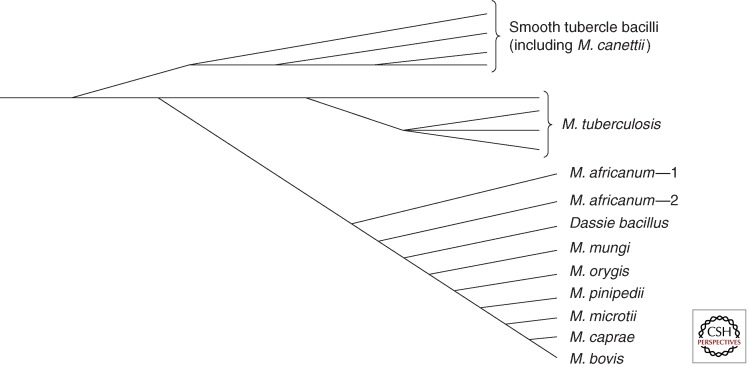

In [2]:
Image('https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4315922/bin/cshperspectmed-TUB-021204_F2.jpg')

In [3]:
seqs=SeqIO.parse('../Morygis_hokkaido.fa','fasta')
new=[]
for s in seqs:   
    s.id=s.id.replace('.','_')
    s.seq = s.seq.upper()
    new.append(s)
#SeqIO.write(new,'myco_genomes/Morygis_hokkaido.fna',format='fasta')

## Orygis SRA data

In [11]:
sra = pd.read_csv('Morygis_SRA.csv')
cols=['BioProject','Run','Sample Name','Host']
sra.groupby(['BioProject','Center Name','geo_loc_name_country']).agg({'Run':np.size}).reset_index()
#sra.iloc[1]

,BioProject,Center Name,geo_loc_name_country,Run
0,PRJNA389109,NEW YORK STATE DEPARTMENT OF HEALTH,USA,8
1,PRJNA575883,THE PENNSYLVANIA STATE UNIVERSITY,Bangladesh,1
2,PRJNA575883,THE PENNSYLVANIA STATE UNIVERSITY,India,25
3,PRJNA576656,ICAR-INDIAN VETERINARY RESEARCH INSTITUTE,India,19


In [44]:
samples = pd.read_csv('orygis_samples.csv')
path='read_data'
for i,row in samples.iterrows():    
    if type(row.run) is str:
        print (row['name'],row.run)
        fname = '../read_data/%s.fastq' %row.run        
        cmd = '/local/SPAdes-3.13.0/bin/spades.py -1 {p}/{n}_1.fastq.gz -2 {p}/{n}_2.fastq.gz --careful -o {p}/{n} -t 15'.format(n=row.run,p=path)
        print (cmd)


Morygis_IK1351 SRR10251185
/local/SPAdes-3.13.0/bin/spades.py -1 read_data/SRR10251185_1.fastq.gz -2 read_data/SRR10251185_2.fastq.gz --careful -o read_data/SRR10251185 -t 15
Morygis_IK1664 SRR10251194
/local/SPAdes-3.13.0/bin/spades.py -1 read_data/SRR10251194_1.fastq.gz -2 read_data/SRR10251194_2.fastq.gz --careful -o read_data/SRR10251194 -t 15
Morygis_IK1660 SRR10251195
/local/SPAdes-3.13.0/bin/spades.py -1 read_data/SRR10251195_1.fastq.gz -2 read_data/SRR10251195_2.fastq.gz --careful -o read_data/SRR10251195 -t 15


In [62]:
def get_fastani(filename):
    import re
    df = pd.read_csv(filename,sep='\t',names=['query','ref','ident','x','y'])
    df['query'] = df['query'].apply(lambda x: re.split(r"[\./]+",x)[1])
    df['ref'] = df['ref'].apply(lambda x: re.split(r"[\./]+",x)[1])
    x = pd.pivot_table(df,index='query',values='ident',columns=['ref'])
    return x

In [63]:
cmd = 'fastANI --ql reference.txt --rl query.txt -o fastani.out -t 12'
#subprocess.check_output(cmd,shell=True)
anim = get_fastani('fastani.out')
anim.to_csv('ani_matrix.csv')

## run nucdiff

In [49]:
path = 'myco_genomes'
#names = ['Mbovis','Morygis','Mcaprae','Mmicroti','Mpinnipedii','Mcanettii','Mafricanum']
names = analysis.run_genomes(path, outpath='myco_results')

myco_genomes/Morygis_IK1664.fna Morygis_IK1664
myco_genomes/BCG_Pasteur.fna BCG_Pasteur
myco_genomes/Morygis_IK1660.fna Morygis_IK1660
myco_genomes/Morygis_LN2011.fna Morygis_LN2011
myco_genomes/Mcanettii.fna Mcanettii
myco_genomes/Mpinnipedii.fna Mpinnipedii
myco_genomes/Mmicroti.fna Mmicroti
myco_genomes/Morygis_IK1351.fna Morygis_IK1351
myco_genomes/MTB_ethiopia.fna MTB_ethiopia
myco_genomes/Morygis_Resp2008.fna Morygis_Resp2008
myco_genomes/Mmungi_BM22813.fna Mmungi_BM22813
myco_genomes/Morygis_Resp2011.fna Morygis_Resp2011
myco_genomes/Mbovis.fna Mbovis
myco_genomes/MTB_beijing.fna MTB_beijing
myco_genomes/Morygis_NIRTAH144.fna Morygis_NIRTAH144
myco_genomes/Mcaprae.fna Mcaprae
myco_genomes/Morygis_112400015.fna Morygis_112400015
myco_genomes/Morygis_Absc2007.fna Morygis_Absc2007
myco_genomes/Mafricanum.fna Mafricanum
myco_genomes/Morygis_hokkaido.fna Morygis_hokkaido


## get nucdiff results
* get RD regions
* get protein annotations

In [50]:
reload(utils)
print (names)

struct, snp =  utils.get_nucdiff_results('myco_results', names)
#struct = struct[(struct.Name=='deletion') | (struct.Name=='insertion')]
struct['RD'] = struct.apply(utils.get_region,1)

subcols = ['ID','Name','start','end','length','descr','RD']
print (struct[:4][subcols])


['Morygis_IK1664', 'BCG_Pasteur', 'Morygis_IK1660', 'Morygis_LN2011', 'Mcanettii', 'Mpinnipedii', 'Mmicroti', 'Morygis_IK1351', 'MTB_ethiopia', 'Morygis_Resp2008', 'Mmungi_BM22813', 'Morygis_Resp2011', 'Mbovis', 'MTB_beijing', 'Morygis_NIRTAH144', 'Mcaprae', 'Morygis_112400015', 'Morygis_Absc2007', 'Mafricanum', 'Morygis_hokkaido']
      ID              Name  start    end  length                         descr RD
1  SV_22  collapsed_repeat  34787  34802      15  collapsed_repeat_34787:34802  -
2  SV_21          deletion  34802  35208     406          deletion_34802:35208  -
3  SV_19         insertion  38981  38982       1         insertion_38981:38982  -
4  SV_20       duplication  38981  38982       1       duplication_38981:38982  -


## presence/absence matrix of events

In [51]:
reload(utils)
rdmat = utils.RD_matrix(struct)
smat = utils.sites_matrix(struct, freq=5)
#snpmat = sites_matrix(snps, freq=5)

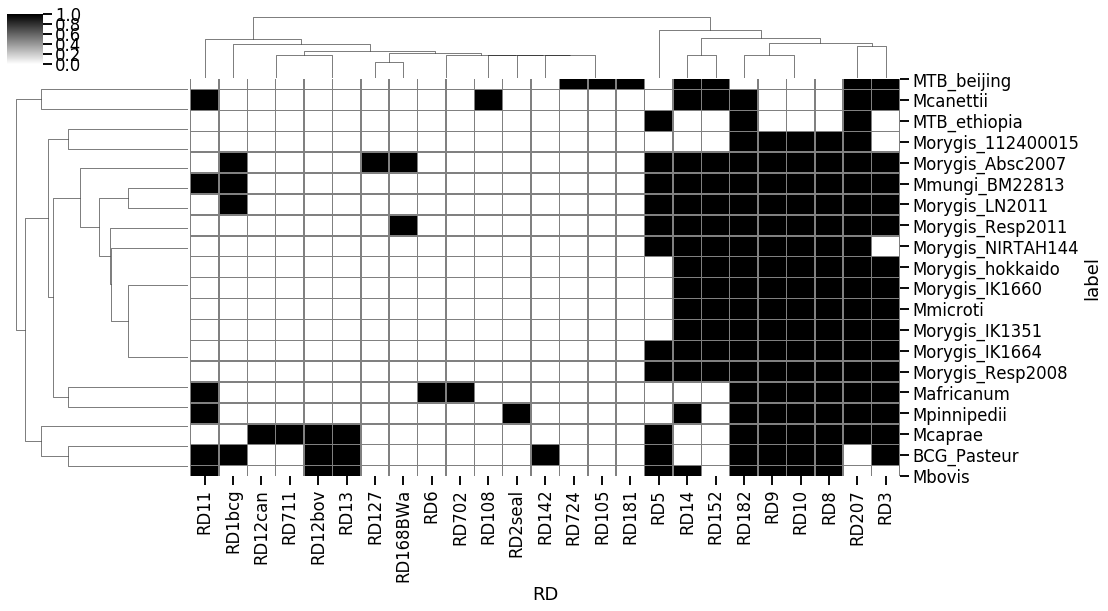

In [52]:
#x=run_RD_checker(rds)
fig = analysis.plot_RD(rdmat.T)
fig.savefig('RD_matrix.png',dpi=150)

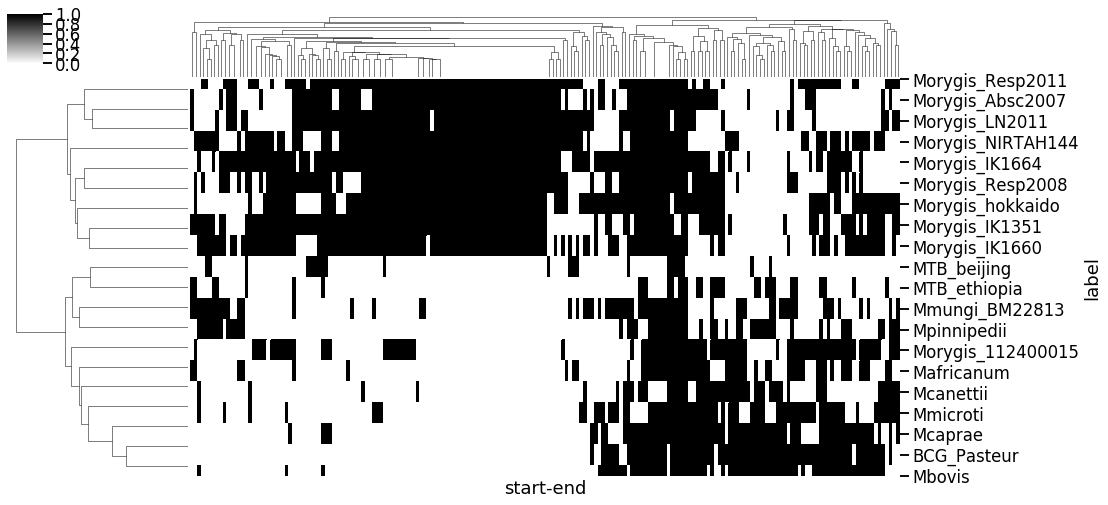

In [55]:
reload(analysis)
fig = analysis.plot_RD(smat.T,lw=0)
fig.savefig('orygis_sites.png',dpi=150)

## summary

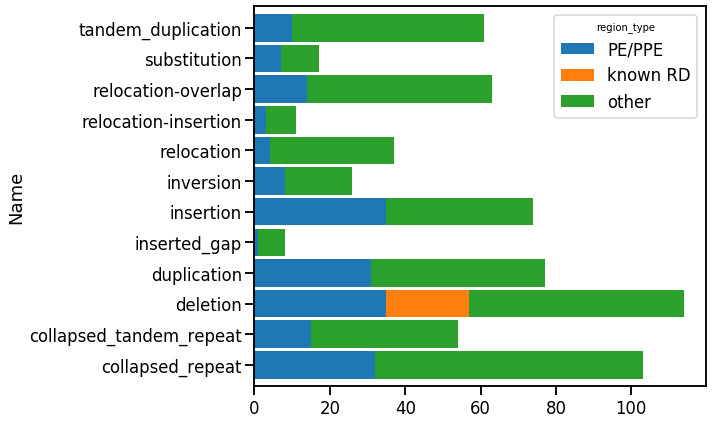

In [56]:
summ=utils.get_summary(struct)
summ
def plot_summary(df):
    s = pd.pivot_table(df,index=['Name'],values=['freq'],columns=['region_type'],aggfunc='count')
    s.columns = s.columns.get_level_values(1)
    fig,ax=plt.subplots(1,1,figsize=(10,6))
    s.plot(kind='barh',stacked=True,width=.9,ax=ax)
    plt.tight_layout()
    fig.savefig('struct_stats.svg')
    
plot_summary(summ)

## find RDs

In [ ]:
def map_regions(coords):
    """Map list of coords to regions of difference and return a dataframe"""
    
    m = []
    RD = pd.read_csv(utils.RD_file,comment='#')
    for c in coords:
        st,end=c
        df = RD[ (st>RD.Start) & (st<RD.Stop) |
                 ((end>RD.Start) & (end<RD.Stop)) |
                 ((st<RD.Start) & (end>RD.Stop))].copy()
        if len(df)>0:
            #print (df)            
            df['start'] = st
            df['end'] = end
            m.append(df)
    m=pd.concat(m)
    return m

m = map_regions(smat.index.values)
#get positions on heatmap of these start locs
xpos = [smat.index.get_loc(i) for i in zip(m.start,m.end)]
labels = list(m.RD_name)

#plot heatmap
g = sns.clustermap(smat.T,cbar=False,figsize=(18,7),xticklabels=False,col_cluster=False,cmap='gray_r',lw=1)
ax=g.ax_heatmap
ax.set_title('common indel events in MTC')
for x in xpos:
    ax.axvline(x=x+.5,linewidth=5,color='r',alpha=0.4)
    
plt.sca(ax)
#plt.xticks(xpos, labels)
#l=ax.set_xticklabels(labels,rotation=45)

## Compare struct changes between mbovis and orygis 

* get common start sites between the orygis and bovis samples
* common snps?

320


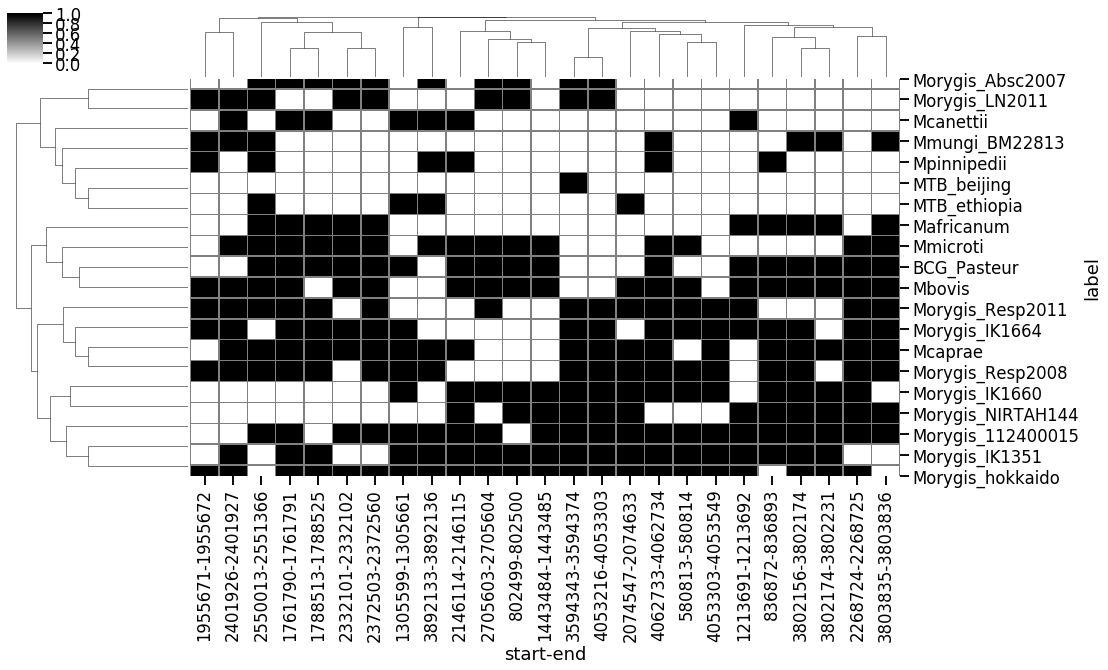

In [57]:
# changes in bovis and orygis but not in others

struct['orygis'] = struct.label.str.contains('Morygis').astype(int)
struct['bovis'] = struct.label.str.contains('Mbovis|caprae').astype(int)
struct['orygis_freq'] = struct.groupby(['descr'])['orygis'].transform(np.sum)
struct['bovis_freq'] = struct.groupby(['descr'])['bovis'].transform(np.sum)
struct['freq'] = struct.groupby(['descr'])['start'].transform(np.size)

so = struct[(struct.orygis_freq>=5) & (struct.freq<=13) & (struct.bovis_freq>=1)]
print (len(so))
so.label.value_counts()
so.descr.unique()
s = utils.get_summary(so)
m = utils.sites_matrix(so, freq=1)
fig = analysis.plot_RD(m.T)
fig.savefig('orygis_mbovis_sites.svg')

,start,end,Name,insertion_length,freq,length,RD,gene,region_type
36,4062733,4062734,collapsed_repeat,0,13,1,-,lpqG,other
10,1761790,1761791,duplication,1,13,1,-,mmpL6,other
25,2550013,2551366,deletion,0,13,1353,RD182,Rv2277c,known RD
11,1761790,1761791,insertion,2150,13,1,-,mmpL6,other
28,3802156,3802174,deletion,0,12,18,-,PE_PGRS52,PE/PPE
27,3594343,3594374,deletion,0,12,31,-,None,other
20,2372503,2372560,collapsed_tandem_repeat,0,12,57,-,dop,other
30,3803835,3803836,duplication,8,11,1,-,PE_PGRS52,PE/PPE
5,836872,836893,deletion,0,11,21,-,PE_PGRS9,PE/PPE
12,1788513,1788525,collapsed_repeat,0,11,12,-,Rv1587c,other


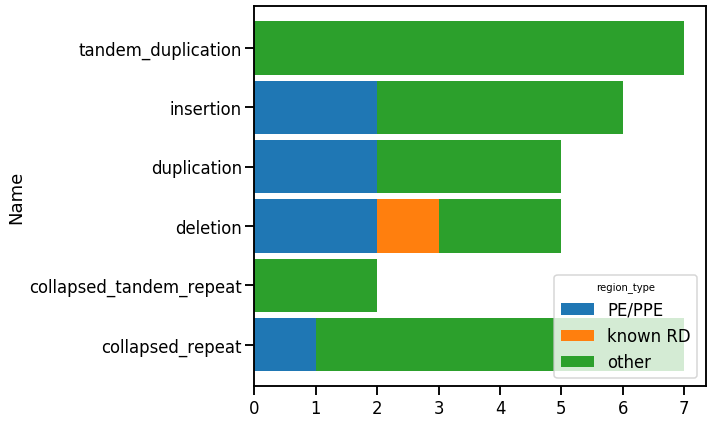

In [61]:
plot_summary(s)
s

562


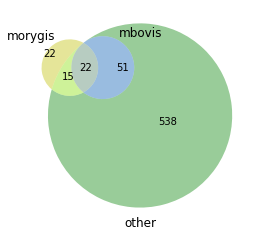

In [18]:
oryg = struct[struct.orygis_freq>=4]
print (len(oryg))
mb = struct[struct.label=='Mbovis']
other = struct[(struct.orygis!=1) ]

from matplotlib_venn import venn3
ax=venn3((set(oryg.descr),set(mb.descr),set(other.descr)),
         ['morygis','mbovis','other'],('y','b','g'))

mat = utils.sites_matrix(oryg, index='descr')
mat = mat[mat.sum(1)>3]
intersect = mat.index

#comm = modiff[modiff.descr.isin(intersect)]
#comm = comm[subcols]
#print('%s common sites' %len(comm))


In [ ]:
comm=comm.sort_values('length',ascending=False)
comm.to_csv('morygis_common.csv')
comm

## known snps in orygis

In [58]:
reload(utils)
snp_summ = utils.get_summary(snp)

In [65]:
genes=['gyrB','Rv2042c']
snp_summ[snp_summ.gene.isin(genes)]

,start,end,Name,descr,ref_bases,query_bases,freq,length,RD,gene,region_type
49,6445,6446,substitution,substitution_6445:6446,G,T,17,1,-,gyrB,other
22362,2288568,2288569,substitution,substitution_2288568:2288569,A,C,10,1,-,Rv2042c,other
51,6716,6717,substitution,substitution_6716:6717,T,C,10,1,-,gyrB,other
46,6108,6109,substitution,substitution_6108:6109,G,A,10,1,-,gyrB,other
41,5515,5516,substitution,substitution_5515:5516,A,G,10,1,-,gyrB,other
44,5751,5752,substitution,substitution_5751:5752,G,A,3,1,-,gyrB,other
48,6405,6406,substitution,substitution_6405:6406,C,T,2,1,-,gyrB,other
